In [1]:
import inspect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Optional, Tuple
from pathlib import Path

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 140)

DATA_DIR = Path('dataset')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'


In [2]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print(train.head())
print('\nShape:', train.shape)
print('\nMissing values per column:\n', train.isna().sum())


  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration MaritalStatus  NumberOfDependents HomeOwnershipStatus  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0      Divorced                 1.0                Rent   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0       Widowed                 1.0            Mortgage   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0       Married                 0.0            Mortgage   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0       Married                 0.0               Other   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0        Single                 2.0                Rent   

   MonthlyDebtPayments  CreditCardUtilizationRate  NumberOfOpenCreditLines  NumberOfCreditInquiries  DebtToIncomeRatio  BankruptcyHistory  \
0               1095.0                   0.151985     

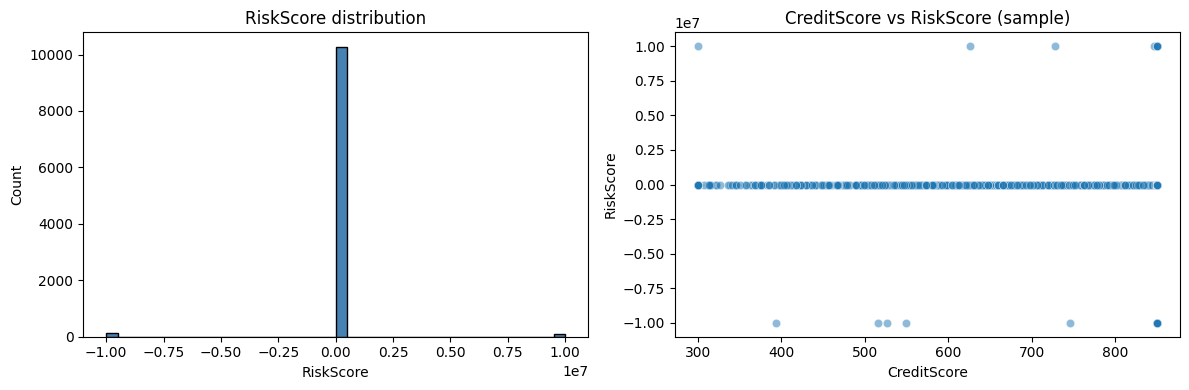

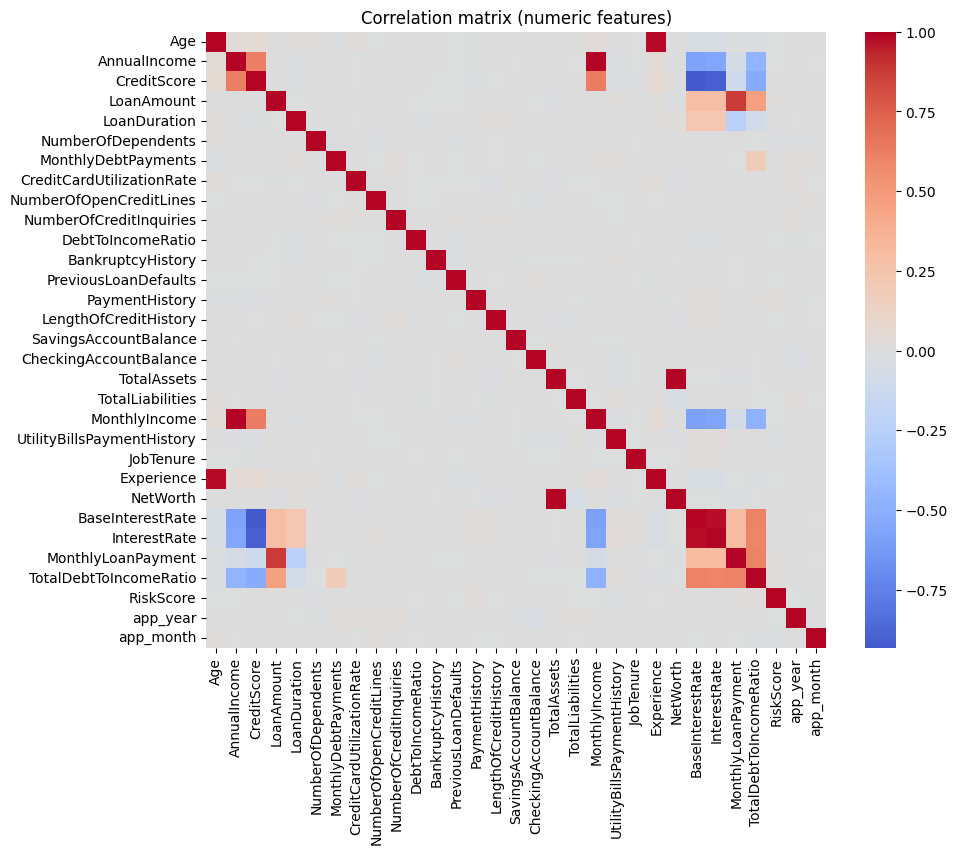

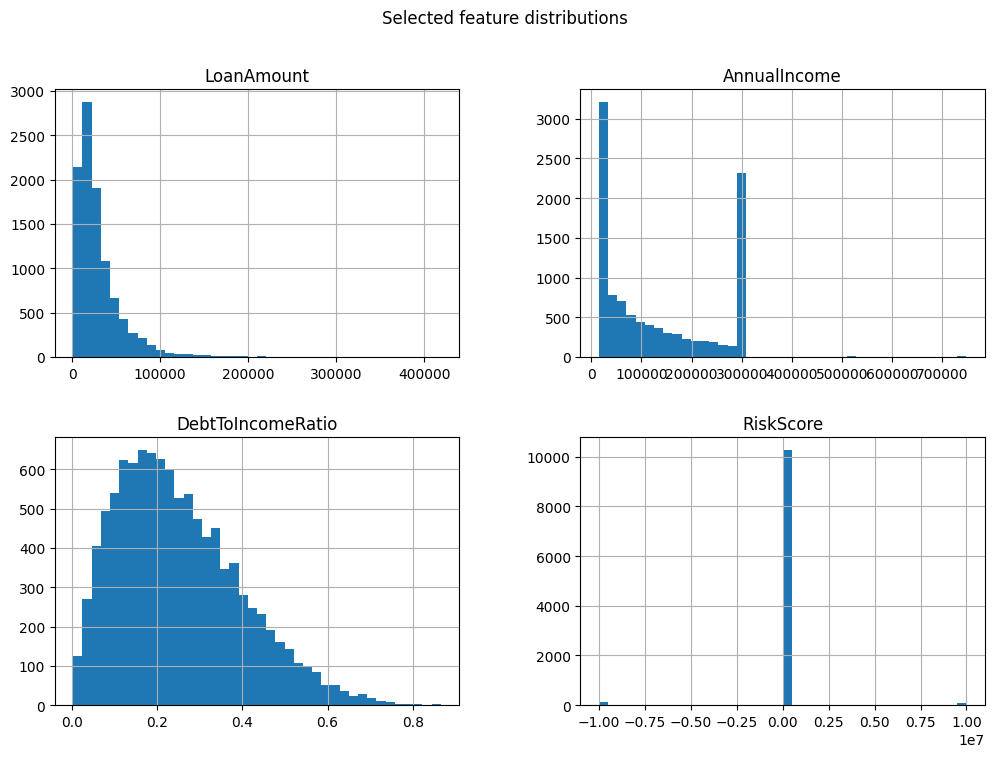

In [3]:
# Basic feature engineering for EDA
train_eda = train.copy()
train_eda['ApplicationDate'] = pd.to_datetime(train_eda['ApplicationDate'], errors='coerce')
train_eda['app_year'] = train_eda['ApplicationDate'].dt.year
train_eda['app_month'] = train_eda['ApplicationDate'].dt.month

numeric_cols = train_eda.select_dtypes(include=[np.number]).columns.tolist()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(train_eda['RiskScore'].dropna(), bins=40, color='steelblue', edgecolor='k')
axs[0].set_title('RiskScore distribution')
axs[0].set_xlabel('RiskScore')
axs[0].set_ylabel('Count')

sns.scatterplot(data=train_eda.sample(1000, random_state=42), x='CreditScore', y='RiskScore', alpha=0.5, ax=axs[1])
axs[1].set_title('CreditScore vs RiskScore (sample)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
corr = train_eda[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation matrix (numeric features)')
plt.show()

train_eda[['LoanAmount', 'AnnualIncome', 'DebtToIncomeRatio', 'RiskScore']].hist(bins=40, figsize=(12, 8))
plt.suptitle('Selected feature distributions')
plt.show()


In [4]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean((y_true - y_pred) ** 2))


def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred)))


def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)


def mape(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    return float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100)


# Quick self-check on tiny arrays
_y = np.array([1, 2, 3])
_pred = np.array([1, 1.5, 2.5])
print('Sanity MSE', mse(_y, _pred))
print('Sanity MAE', mae(_y, _pred))
print('Sanity R2', r2_score(_y, _pred))
print('Sanity MAPE', mape(_y, _pred))


Sanity MSE 0.16666666666666666
Sanity MAE 0.3333333333333333
Sanity R2 0.75
Sanity MAPE 13.888888828703704


In [5]:
# Advanced feature engineering helpers (inspired by reference solution)
EPS = 1e-3
FEATURE_SELECTION_PERCENTILE = 30


def signed_log1p(data: np.ndarray) -> np.ndarray:
    return np.sign(data) * np.log1p(np.abs(data))


def extract_date_parts(df: pd.DataFrame, column: str) -> None:
    if column not in df.columns:
        return
    parsed = pd.to_datetime(df[column], errors="coerce")
    df[f"{column}_Year"] = parsed.dt.year
    df[f"{column}_Month"] = parsed.dt.month
    df[f"{column}_DayOfWeek"] = parsed.dt.dayofweek
    df.drop(columns=[column], inplace=True)


def add_bins(df: pd.DataFrame, column: str, bins: list, fmt: str = "num") -> None:
    if column not in df.columns:
        return
    labels = []
    for i in range(len(bins) - 1):
        lo, hi = bins[i], bins[i + 1]
        if np.isinf(hi):
            labels.append(f"{lo}{'+' if fmt=='num' else ''}")
        else:
            labels.append(f"{lo}-{hi}")
    df[f"{column}Band"] = (
        pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
        .astype(str)
    )


def augment_features(df: pd.DataFrame) -> None:
    # ratios and interactions
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + EPS)

    total_debt = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtServiceRatio"] = total_debt / (df["MonthlyIncome"] + EPS)
    df["DisposableIncome"] = df["MonthlyIncome"] - total_debt

    df["AssetCoverage"] = df["TotalAssets"] / (df["TotalLiabilities"] + EPS)
    df["LiabilityGap"] = df["TotalLiabilities"] - df["TotalAssets"]
    df["SignedLogLiabilityGap"] = signed_log1p(df["LiabilityGap"])
    df.drop(columns=["LiabilityGap"], inplace=True)

    df["NetWorthToLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + EPS)
    df["NetWorthToIncome"] = df["NetWorth"] / (df["AnnualIncome"] + EPS)

    df["UtilizationPerLine"] = df["CreditCardUtilizationRate"] / (df["NumberOfOpenCreditLines"] + 1)
    df["InquiryPerLine"] = df["NumberOfCreditInquiries"] / (df["NumberOfOpenCreditLines"] + 1)

    df["IncomePerDependent"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExperienceToAge"] = df["Experience"] / (df["Age"] + EPS)
    df["LoanDurationYears"] = df["LoanDuration"] / 12.0

    df["CreditHistoryToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + EPS)
    df["IncomeDiscrepancy"] = df["AnnualIncome"] - (df["MonthlyIncome"] * 12.0)
    df["AgeAfterExperience"] = df["Age"] - df["Experience"]

    parsed = pd.to_datetime(df["ApplicationDate"], errors="coerce")
    df["ApplicationDateWeek"] = parsed.dt.isocalendar().week.astype(float)
    df["ApplicationDateDayOfYear"] = parsed.dt.dayofyear
    df["ApplicationDateQuarter"] = parsed.dt.quarter

    # some useful discretisations
    add_bins(df, "CreditScore", [300, 580, 620, 660, 700, 740, 780, 820, 900])
    add_bins(df, "AnnualIncome", [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf])
    add_bins(df, "TotalDebtToIncomeRatio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf])
    add_bins(df, "InterestRate", [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf])
    add_bins(df, "Age", [18, 30, 45, 60, np.inf])
    add_bins(df, "LoanAmount", [0, 30000, 60000, 100000, np.inf])
    add_bins(df, "MonthlyIncome", [0, 2000, 4000, 6000, 8000, 12000, 16000, 25000, np.inf])
    add_bins(df, "CreditCardUtilizationRate", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, np.inf])


In [6]:
def z_score_scale(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = np.asarray(X, dtype=float)
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    return (X - mean) / std, mean, std


def min_max_scale(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = np.asarray(X, dtype=float)
    min_v = X.min(axis=0)
    max_v = X.max(axis=0)
    scale = (max_v - min_v)
    scale[scale == 0] = 1e-8
    return (X - min_v) / scale, min_v, scale


In [7]:
def build_feature_matrix(train_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    train_df = train_df.copy()
    test_df = test_df.copy()

    # clean target: drop NaNs and extreme outliers, clip to [0, 100]
    mask = ~train_df['RiskScore'].isna()
    train_df = train_df.loc[mask].reset_index(drop=True)
    train_df = train_df[train_df['RiskScore'].abs() <= 200].reset_index(drop=True)
    train_df['RiskScore'] = train_df['RiskScore'].clip(0.0, 100.0)

    y = train_df['RiskScore'].reset_index(drop=True)
    train_df = train_df.drop(columns=['RiskScore'])

    for df in (train_df, test_df):
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        df['app_year'] = df['ApplicationDate'].dt.year
        df['app_month'] = df['ApplicationDate'].dt.month
        df.drop(columns=['ApplicationDate'], inplace=True)

    combined = pd.concat([train_df, test_df], axis=0, ignore_index=True)

    cat_cols = combined.select_dtypes(include=['object']).columns
    num_cols = [c for c in combined.columns if c not in cat_cols]

    for col in num_cols:
        combined[col] = combined[col].fillna(combined[col].median())
    for col in cat_cols:
        combined[col] = combined[col].fillna(combined[col].mode().iloc[0])

    # stabilize numeric scale: signed log1p transform
    for col in num_cols:
        combined[col] = np.sign(combined[col]) * np.log1p(np.abs(combined[col]))

    combined_encoded = pd.get_dummies(combined, drop_first=True)

    X_train = combined_encoded.iloc[: len(train_df)].reset_index(drop=True)
    X_test = combined_encoded.iloc[len(train_df) :].reset_index(drop=True)
    return X_train, X_test, y.reset_index(drop=True)


X_df, X_test_df, y = build_feature_matrix(train, test)
print('Encoded shapes', X_df.shape, X_test_df.shape)
print('Target missing after drop:', y.isna().sum())


Encoded shapes (10272, 47) (5000, 47)
Target missing after drop: 0


In [8]:
@dataclass
class MyLinearRegression:
    method: str = 'normal'  # 'normal', 'gd', 'sgd'
    lr: float = 0.01
    epochs: int = 2000
    batch_size: int = 32
    l1: float = 0.0
    l2: float = 0.0
    lp: Optional[float] = None  # if set, add |w|^p
    random_state: int = 42
    tol: float = 1e-6

    def _add_bias(self, X: np.ndarray) -> np.ndarray:
        return np.c_[np.ones((X.shape[0], 1)), X]

    def _regularization_grad(self, w: np.ndarray) -> np.ndarray:
        reg = np.zeros_like(w)
        w_no_bias = w.copy()
        w_no_bias[0] = 0  # do not regularize bias
        if self.l1 > 0:
            reg += self.l1 * np.sign(w_no_bias)
        if self.l2 > 0:
            reg += 2 * self.l2 * w_no_bias
        if self.lp is not None and self.lp > 0:
            # add small eps to avoid divide-by-zero when lp < 1
            eps = 1e-8
            base = np.abs(w_no_bias) + eps
            reg += self.lp * np.sign(w_no_bias) * (base ** (self.lp - 1))
        return reg

    def fit(self, X: np.ndarray, y: np.ndarray):
        rng = np.random.default_rng(self.random_state)
        Xb = self._add_bias(X)
        y = y.reshape(-1, 1)

        if self.method == 'normal':
            eye = np.eye(Xb.shape[1])
            eye[0, 0] = 0  # don't regularize bias
            xtx = Xb.T @ Xb + self.l2 * eye
            xty = Xb.T @ y
            self.coef_ = np.linalg.pinv(xtx) @ xty
            return self

        # initialize weights
        self.coef_ = rng.normal(scale=0.01, size=(Xb.shape[1], 1))

        if self.method == 'gd':
            for _ in range(self.epochs):
                preds = Xb @ self.coef_
                error = preds - y
                grad = (Xb.T @ error) / len(Xb) + self._regularization_grad(self.coef_)
                step = self.lr * grad
                self.coef_ -= step
                if np.linalg.norm(step) < self.tol:
                    break
        elif self.method == 'sgd':
            for epoch in range(self.epochs):
                indices = rng.permutation(len(Xb))
                for start in range(0, len(Xb), self.batch_size):
                    batch_idx = indices[start : start + self.batch_size]
                    X_batch = Xb[batch_idx]
                    y_batch = y[batch_idx]
                    preds = X_batch @ self.coef_
                    error = preds - y_batch
                    grad = (X_batch.T @ error) / len(X_batch) + self._regularization_grad(self.coef_)
                    self.coef_ -= self.lr * grad
                # simple early stop based on full-batch gradient
                full_grad = (Xb.T @ (Xb @ self.coef_ - y)) / len(Xb)
                if np.linalg.norm(full_grad) < self.tol:
                    break
        else:
            raise ValueError('Unknown method')
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        Xb = self._add_bias(X)
        return (Xb @ self.coef_).ravel()


In [9]:
class ManualPipeline:
    def __init__(
        self,
        reg_method: str = 'sklearn',
        lr: float = 0.01,
        epochs: int = 1000,
        batch_size: int = 32,
        verbose: bool = False,
        scaler_type: str = 'zscore',
    ):
        self.reg_method = reg_method
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.scaler_type = scaler_type

        self.num_medians = None
        self.cat_modes = None
        self.num_mean = None
        self.num_std = None
        self.num_min = None
        self.num_max = None
        self.poly = None
        self.poly_mean = None
        self.poly_std = None
        self.ohe = None
        self.selector = None
        self.reg = None

    def fit(self, X: pd.DataFrame, y: pd.Series, numeric_cols, cat_cols):
        X = X.copy()
        # fill missing
        self.num_medians = X[numeric_cols].median()
        X[numeric_cols] = X[numeric_cols].fillna(self.num_medians)

        self.cat_modes = X[cat_cols].mode().iloc[0] if len(cat_cols) > 0 else None
        if len(cat_cols) > 0:
            X[cat_cols] = X[cat_cols].fillna(self.cat_modes)

        # log-transform numerics
        X[numeric_cols] = signed_log1p(X[numeric_cols])

        # scaling
        if self.scaler_type == 'zscore':
            self.num_mean = X[numeric_cols].mean()
            self.num_std = X[numeric_cols].std().replace(0, 1)
            X[numeric_cols] = (X[numeric_cols] - self.num_mean) / self.num_std
        elif self.scaler_type == 'minmax':
            self.num_min = X[numeric_cols].min()
            self.num_max = X[numeric_cols].max()
            X[numeric_cols] = (X[numeric_cols] - self.num_min) / (self.num_max - self.num_min + EPS)

        # polynomial features on numerics
        self.poly = PolynomialFeatures(degree=2, include_bias=False)
        self.poly.fit(X[numeric_cols])
        poly_train = self.poly.transform(X[numeric_cols])
        poly_cols = self.poly.get_feature_names_out(numeric_cols)
        poly_df = pd.DataFrame(poly_train, columns=poly_cols, index=X.index)

        self.poly_mean = poly_df.mean()
        self.poly_std = poly_df.std().replace(0, 1)
        poly_df = (poly_df - self.poly_mean) / self.poly_std

        # one-hot for categoricals
        if len(cat_cols) > 0:
            ohe_kwargs = {"handle_unknown": "ignore"}
            if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
                ohe_kwargs["sparse_output"] = False
            else:
                ohe_kwargs["sparse"] = False
            self.ohe = OneHotEncoder(**ohe_kwargs)
            self.ohe.fit(X[cat_cols])
            cat_encoded = self.ohe.transform(X[cat_cols])
            cat_cols_encoded = self.ohe.get_feature_names_out(cat_cols)
            cat_df = pd.DataFrame(cat_encoded, columns=cat_cols_encoded, index=X.index)
        else:
            cat_df = pd.DataFrame(index=X.index)

        X_full = pd.concat([poly_df, cat_df], axis=1)

        # univariate feature selection
        self.selector = SelectPercentile(score_func=f_regression, percentile=FEATURE_SELECTION_PERCENTILE)
        self.selector.fit(X_full, y)
        X_sel = self.selector.transform(X_full)

        # linear regression backend
        if self.reg_method == 'sklearn':
            self.reg = LinearRegression()
        else:
            # use our custom implementation
            self.reg = MyLinearRegression(method=self.reg_method, lr=self.lr, epochs=self.epochs, batch_size=self.batch_size)
        self.reg.fit(X_sel, y)

    def transform(self, X: pd.DataFrame, numeric_cols, cat_cols):
        X = X.copy()
        X[numeric_cols] = X[numeric_cols].fillna(self.num_medians)
        if len(cat_cols) > 0 and self.cat_modes is not None:
            X[cat_cols] = X[cat_cols].fillna(self.cat_modes)

        X[numeric_cols] = signed_log1p(X[numeric_cols])

        if self.scaler_type == 'zscore':
            X[numeric_cols] = (X[numeric_cols] - self.num_mean) / self.num_std
        elif self.scaler_type == 'minmax':
            X[numeric_cols] = (X[numeric_cols] - self.num_min) / (self.num_max - self.num_min + EPS)

        poly_test = self.poly.transform(X[numeric_cols])
        poly_cols = self.poly.get_feature_names_out(numeric_cols)
        poly_df = pd.DataFrame(poly_test, columns=poly_cols, index=X.index)
        poly_df = (poly_df - self.poly_mean) / self.poly_std

        if len(cat_cols) > 0 and self.ohe is not None:
            cat_encoded = self.ohe.transform(X[cat_cols])
            cat_cols_encoded = self.ohe.get_feature_names_out(cat_cols)
            cat_df = pd.DataFrame(cat_encoded, columns=cat_cols_encoded, index=X.index)
        else:
            cat_df = pd.DataFrame(index=X.index)

        X_full = pd.concat([poly_df, cat_df], axis=1)
        X_sel = self.selector.transform(X_full)
        return X_sel

    def predict(self, X: pd.DataFrame, numeric_cols, cat_cols):
        X_sel = self.transform(X, numeric_cols, cat_cols)
        return self.reg.predict(X_sel)


In [10]:
from sklearn.model_selection import KFold


def cross_val_score_manual(model_builder, X: np.ndarray, y: np.ndarray, k: int = 5, metric=mse, **model_kwargs):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X):
        model = model_builder(**model_kwargs)
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[val_idx])
        scores.append(metric(y[val_idx], preds))
    return np.array(scores)


def leave_one_out_cv(model_builder, X: np.ndarray, y: np.ndarray, metric=mse, **model_kwargs):
    kf = KFold(n_splits=len(X))
    scores = []
    for train_idx, val_idx in kf.split(X):
        model = model_builder(**model_kwargs)
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[val_idx])
        scores.append(metric(y[val_idx], preds))
    return np.array(scores)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn import metrics as sk_metrics

X = X_df.to_numpy(dtype=float)
X_test_np = X_test_df.to_numpy(dtype=float)
y_np = y.values.astype(float)

# scale features for iterative methods
X_z, mean_z, std_z = z_score_scale(X)
X_minmax, min_v, scale_v = min_max_scale(X)

X_train, X_val, y_train, y_val = train_test_split(X_z, y_np, test_size=0.2, random_state=42)

# Normal equation
model_normal = MyLinearRegression(method='normal', l2=0.001).fit(X_train, y_train)
pred_val_normal = model_normal.predict(X_val)
print('Normal eq MSE', mse(y_val, pred_val_normal))

# Batch gradient descent
model_gd = MyLinearRegression(method='gd', lr=0.01, epochs=1000, l2=0.001).fit(X_train, y_train)
pred_val_gd = model_gd.predict(X_val)
print('GD MSE', mse(y_val, pred_val_gd))

# SGD
model_sgd = MyLinearRegression(method='sgd', lr=0.01, epochs=200, batch_size=64, l2=0.001).fit(X_train, y_train)
pred_val_sgd = model_sgd.predict(X_val)
print('SGD MSE', mse(y_val, pred_val_sgd))

# sklearn comparison
sk_lin = LinearRegression().fit(X_train, y_train)
sk_pred = sk_lin.predict(X_val)
print('sklearn LinearRegression MSE', sk_metrics.mean_squared_error(y_val, sk_pred))

sgd_reg = SGDRegressor(max_iter=1000, penalty='l2', alpha=0.001, learning_rate='invscaling', eta0=0.01)
sgd_reg.fit(X_train, y_train)
sk_sgd_pred = sgd_reg.predict(X_val)
print('sklearn SGDRegressor MSE', sk_metrics.mean_squared_error(y_val, sk_sgd_pred))


Normal eq MSE 40.903376010416196
GD MSE 42.02960080597996
SGD MSE 40.951993257450496
sklearn LinearRegression MSE 40.90337423701757
sklearn SGDRegressor MSE 41.17377574040887


In [12]:
# K-fold cross-validation on a manageable subset for speed
subset = 2000
X_small = X_z[:subset]
y_small = y_np[:subset]

cv_scores = cross_val_score_manual(MyLinearRegression, X_small, y_small, k=5, metric=mse, method='gd', lr=0.01, epochs=800, l2=0.001)
print('5-fold MSE mean', cv_scores.mean())

# Leave-one-out on very small slice to demonstrate implementation
loo_slice = 200
loo_scores = leave_one_out_cv(MyLinearRegression, X_small[:loo_slice], y_small[:loo_slice], metric=mse, method='normal', l2=0.001)
print('LOO MSE mean (200 pts)', loo_scores.mean())


5-fold MSE mean 39.844837306079356
LOO MSE mean (200 pts) 50.13633750140375


In [13]:
# Regularization demo (L1 / Elastic / Lp)
reg_models = {
    'L1 strong': MyLinearRegression(method='gd', lr=0.01, epochs=800, l1=0.01),
    'L2 ridge': MyLinearRegression(method='normal', l2=0.1),
    'Elastic': MyLinearRegression(method='gd', lr=0.01, epochs=800, l1=0.005, l2=0.01),
    'Lp p=0.5': MyLinearRegression(method='gd', lr=0.005, epochs=800, lp=0.5, l2=0.0),
}

for name, mdl in reg_models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_val)
    print(f'{name} MSE', mse(y_val, preds))


L1 strong MSE 42.3684918160377
L2 ridge MSE 40.90355229776328
Elastic MSE 42.47640130251177
Lp p=0.5 MSE 50.16587229904314


In [14]:
# Advanced pipeline for Kaggle submission (closer to reference)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Reload raw data to avoid interference from previous preprocessing
train_adv = pd.read_csv(TRAIN_PATH)
test_adv = pd.read_csv(TEST_PATH)

target_column = 'RiskScore'
id_column = 'ID'

# Clean target: drop NaNs, extreme outliers, clip to [0, 100]
train_adv = train_adv.dropna(subset=[target_column])
train_adv = train_adv[train_adv[target_column].abs() <= 200].reset_index(drop=True)
train_adv[target_column] = train_adv[target_column].clip(0.0, 100.0)

# Feature engineering
augment_features(train_adv)
augment_features(test_adv)

extract_date_parts(train_adv, 'ApplicationDate')
extract_date_parts(test_adv, 'ApplicationDate')

# Simple ordinal mapping for education
education_mapping = {
    'High School': 1,
    'Associate': 2,
    'Bachelor': 3,
    'Master': 4,
    'Doctorate': 5,
}
for df in (train_adv, test_adv):
    if 'EducationLevel' in df.columns:
        df['EducationLevel'] = df['EducationLevel'].map(education_mapping).fillna(0).astype(float)

X_adv = train_adv.drop(columns=[target_column])
if id_column in X_adv.columns:
    X_adv = X_adv.drop(columns=[id_column])

y_adv = train_adv[target_column]

if id_column in test_adv.columns:
    test_ids_adv = test_adv[id_column].reset_index(drop=True)
    X_test_adv = test_adv.drop(columns=[id_column]).copy()
else:
    test_ids_adv = pd.Series(np.arange(len(test_adv)), name=id_column)
    X_test_adv = test_adv.copy()

numeric_cols_adv = [c for c in X_adv.columns if np.issubdtype(X_adv[c].dtype, np.number)]
cat_cols_adv = [c for c in X_adv.columns if c not in numeric_cols_adv]

# Quick hold-out validation to check that MSE is reasonable
X_tr, X_val2, y_tr, y_val2 = train_test_split(X_adv, y_adv, test_size=0.2, random_state=42)
pipe = ManualPipeline(reg_method='sklearn', scaler_type='zscore')
pipe.fit(X_tr, y_tr, numeric_cols_adv, cat_cols_adv)
val_pred2 = pipe.predict(X_val2, numeric_cols_adv, cat_cols_adv)
print('Advanced pipeline hold-out MSE:', mean_squared_error(y_val2, val_pred2))

# Train on full data and predict for Kaggle
pipe_full = ManualPipeline(reg_method='sklearn', scaler_type='zscore')
pipe_full.fit(X_adv, y_adv, numeric_cols_adv, cat_cols_adv)
final_preds_adv = pipe_full.predict(X_test_adv, numeric_cols_adv, cat_cols_adv)
final_preds_adv = np.clip(final_preds_adv, 0.0, 100.0)

submission = pd.DataFrame({'ID': test_ids_adv, 'RiskScore': final_preds_adv})
submission.to_csv('submission.csv', index=False)
submission.head()


Advanced pipeline hold-out MSE: 27.02741305281684


,ID,RiskScore
0,0,34.393232
1,1,53.387833
2,2,28.452593
3,3,34.384413
4,4,36.410337
